In [342]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from adjustText import adjust_text
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import gseapy as gp

In [58]:
model = '/Users/connormullins/Excel sheets/Model.csv'
osm = '/Users/connormullins/Excel sheets/OmicsSomaticMutations.csv'
reads = '/Users/connormullins/Downloads/OmicsExpressionGenesExpectedCountProfile.csv'
profile = '/Users/connormullins/Downloads/OmicsProfiles.csv'

In [59]:
model_df = pd.read_csv(model, header=0, index_col=0)
osm_df = pd.read_csv(osm, header=0, low_memory=False)
reads_df = pd.read_csv(reads, header=0, low_memory=False)
profile_df = pd.read_csv(profile, header=0, low_memory=False)

In [395]:
cancer_type = "COAD"
protein = "KRAS"
gene_change = "p.A146T"

In [396]:
#filter to get only mutated genes
cancer_filter = model_df[model_df['OncotreeCode'] == cancer_type]
osm_filter_pie = cancer_filter.merge(osm_df, on=['ModelID'], how='inner')
protein_filter = osm_filter_pie[(osm_filter_pie['HugoSymbol'] == protein)]
protein_change_filter = protein_filter[(protein_filter['ProteinChange']== gene_change)]
protein_change_filter = protein_change_filter.filter(['ModelID'])

In [397]:
#retrieve wt cell lines-- models have same oncotree code but not gene mutation specified
cancer_filter = cancer_filter.reset_index()
cancer_filter = cancer_filter.filter(['ModelID'])
protein_filter = protein_filter.filter(['ModelID'])
wt_and_mutant = pd.concat([cancer_filter, protein_filter])
wt_gene = wt_and_mutant.drop_duplicates(keep = False)

In [398]:
# convert modelID to ProfileID
profileid = wt_gene.merge(profile_df, on=['ModelID'], how='inner')
profileid = profileid['ProfileID']
profileid = pd.DataFrame(profileid)

In [399]:
# mut profile id
mut_profile = protein_change_filter.merge(profile_df, on=['ModelID'], how='inner')
mut_profile = mut_profile['ProfileID']
mut_profile = pd.DataFrame(mut_profile)
mut_reads = mut_profile.merge(reads_df, on=['ProfileID'], how='inner')
mut_profile['genotype'] = 'MUT'

In [400]:
# prepare for deseq2
wt_reads = profileid.merge(reads_df, on=['ProfileID'], how='inner')
wt_reads.set_index('ProfileID')
counts = pd.concat([wt_reads, mut_reads])
counts = counts.fillna(0)
#counts = counts.drop(['genotype'], axis = 1)
counts = counts.set_index('ProfileID')
counts = counts.astype(int)

In [401]:
profileid['genotype'] = 'WT'
metadata = pd.concat([profileid, mut_profile])
metadata = metadata.merge(counts, on=['ProfileID'], how='inner')
metadata = metadata.iloc[:, :2]
metadata = metadata.set_index('ProfileID')

In [402]:
dds = DeseqDataSet(counts = counts,
            metadata = metadata,
            design_factors = "genotype")

In [403]:
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 4.12 seconds.

Fitting dispersion trend curve...
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 5.75 seconds.

Fitting LFCs...
... done in 3.00 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 2311 outlier genes.

Fitting dispersions...
... done in 0.61 seconds.

Fitting MAP dispersions...
... done in 0.66 seconds.

Fitting LFCs...
... done in 0.49 seconds.



In [404]:
stat_res = DeseqStats(dds, contrast = ('genotype','MUT','WT'))
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: genotype MUT vs WT
                               baseMean  log2FoldChange     lfcSE      stat  \
TSPAN6 (ENSG00000000003)    4582.561440       -0.645320  1.054272 -0.612100   
TNMD (ENSG00000000005)        18.945043       -3.633205  2.631577 -1.380619   
DPM1 (ENSG00000000419)      5283.016664       -0.504302  0.454517 -1.109535   
SCYL3 (ENSG00000000457)      995.691129        0.381470  0.443836  0.859484   
C1orf112 (ENSG00000000460)  1062.925984       -0.681883  0.392673 -1.736517   
...                                 ...             ...       ...       ...   
SLIT1 (ENSG00000187122)      121.202456        3.147363  1.245996  2.525981   
LYPD6 (ENSG00000187123)      665.839431       -2.811492  1.276767 -2.202040   
AKR1C1 (ENSG00000187134)     844.054171       -0.786269  1.265558 -0.621283   
VSTM2B (ENSG00000187135)       0.448278       -1.128282  5.850018 -0.192868   
FOXD3 (ENSG00000187140)        2.610609        2.734193  1.711356  1.59767

... done in 0.71 seconds.



In [405]:
res = stat_res.results_df
res = res.reset_index()
res['symbol'] = res['index'].apply(lambda x: x.split(' ')[0])
res['nlogFDR'] = -np.log(res['padj'])
res

,index,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,symbol,nlogFDR
0,TSPAN6 (ENSG00000000003),4582.561440,-0.645320,1.054272,-0.612100,0.540472,0.998939,TSPAN6,0.001062
1,TNMD (ENSG00000000005),18.945043,-3.633205,2.631577,-1.380619,0.167396,0.998939,TNMD,0.001062
2,DPM1 (ENSG00000000419),5283.016664,-0.504302,0.454517,-1.109535,0.267200,0.998939,DPM1,0.001062
3,SCYL3 (ENSG00000000457),995.691129,0.381470,0.443836,0.859484,0.390073,0.998939,SCYL3,0.001062
4,C1orf112 (ENSG00000000460),1062.925984,-0.681883,0.392673,-1.736517,0.082473,0.954629,C1orf112,0.046433
...,...,...,...,...,...,...,...,...,...
16378,SLIT1 (ENSG00000187122),121.202456,3.147363,1.245996,2.525981,0.011538,0.634927,SLIT1,0.454245
16379,LYPD6 (ENSG00000187123),665.839431,-2.811492,1.276767,-2.202040,0.027662,0.783846,LYPD6,0.243543
16380,AKR1C1 (ENSG00000187134),844.054171,-0.786269,1.265558,-0.621283,0.534414,0.998939,AKR1C1,0.001062
16381,VSTM2B (ENSG00000187135),0.448278,-1.128282,5.850018,-0.192868,0.847062,0.998939,VSTM2B,0.001062


In [406]:
ranking = res[['symbol', 'stat']].dropna().sort_values('stat', ascending = False)
ranking = ranking.drop_duplicates('symbol')
ranking

,symbol,stat
1016,ZFY,8.041486
6176,RPS4Y1,6.157387
16268,PDE2A,6.046128
9918,MICU3,5.500757
7136,AGT,5.436454
...,...,...
10547,LY6E,-4.222995
4196,NUP155,-4.334708
14204,PHETA2,-4.466766
11469,OSR2,-4.471415


In [407]:
kegg = gp.read_gmt(path = '/Users/connormullins/Downloads/c2.cp.kegg_medicus.v2024.1.Hs.symbols.gmt')
pid = gp.read_gmt(path = '/Users/connormullins/Downloads/c2.cp.pid.v2024.1.Hs.symbols.gmt')
biocarta = gp.read_gmt(path = '/Users/connormullins/Downloads/c2.cp.biocarta.v2024.1.Hs.symbols (1).gmt')

In [408]:
pre_res = gp.prerank(rnk = ranking,
                     gene_sets = pid,
                     seed = 6, permutation_num = 1000)

2024-12-03 18:18:43,424 [WARNING] Duplicated values found in preranked stats: 2.94% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


In [409]:
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes']])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes']).sort_values('fdr').reset_index(drop = True)
out_df = out_df[out_df['fdr'] < 0.05]
out_df['abs nes'] = abs(out_df['nes'])

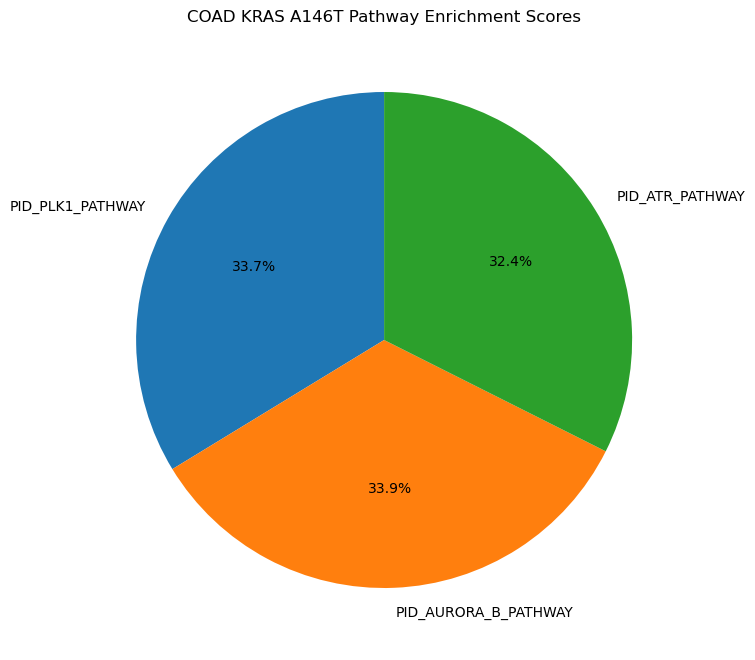

In [410]:
plt.figure(figsize=(8, 12))
plt.pie(out_df['abs nes'], labels=out_df['Term'], autopct='%1.1f%%', startangle=90)
gene_change = gene_change.replace("p.", "")
plt.title(f'{cancer_type} {protein} {gene_change} Pathway Enrichment Scores')
#plt.savefig('/Users/connormullins/Downloads/PAAD_G12R_GSEA.png', dpi =  1200)
plt.show()